# Monte Carlo calculation of volumes and areas 

This notebook contains the Monte Carlo (MC) calculations of volumes and areas for the problem of two spheres ( 3d "discs") in a hard box.

In [1]:
using Distributions

In [2]:
h1 = 1
h2 = 1.5
h3 = 1.75

1.75

Exact analytical expressions derived in the paper:

In [84]:

# esta es otra hjay que cambiarla
cte = 3π/2   # E = 1/2 => abs(v^2) = 1 
sr2= sqrt(2)

# Esto puede no ser valido para 3d
# de hecho ninguno de estos aplica para 3D!
rhmax = h1/4  # maximum radius for which horizontal hop possible
rvmax = h2/4  # maximum radius for which vertical hop possible
rpmax = h3/4  
#rmax = ( h + w - √(2*h*w) ) / 2   # maximum possible radius for discs

volBox(a1, a2, a3) = 64 *a1^2*a2^2*a3^2
volNegfree(a1, a2, a3, r) = 64* ( (sr2*r)^3*π/6*a1*a2*a3
                            -(sr2*r)^4/16*π*(a1*a2+a2*a3+a3*a1)
                            +(sr2*r)^5/15*(a1+a2+a3)
                            -(sr2*r)^6/48)


function vol(a, b, c, r)
    result = volBox(a, b, c) - volNegfree(a, b, c, r)
    
    return result
end 

vol (generic function with 1 method)

In [77]:
testvolneg(r)=volNegfree(h1/2-r, h2/2-r, h3/2-r,r)
testvolbox(r)=volBox(h1/2-r, h2/2-r, h3/2-r)

testvolbox (generic function with 1 method)

In [78]:
rangsr=0:0.01:0.285
volxul=map(testvolneg, rangsr);
volb=map(testvolbox, rangsr);

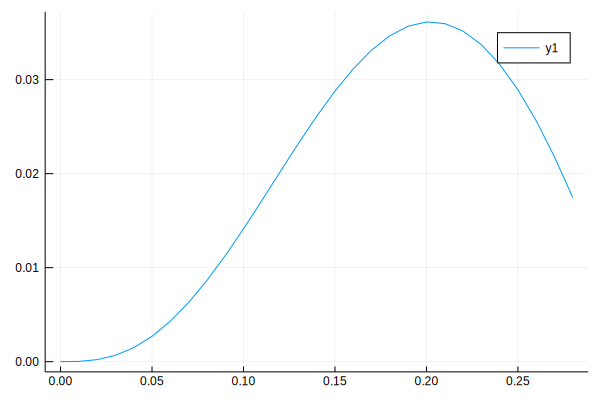

In [80]:
plot(rangsr, volxul)
#plot!(rangsr, volb)

In [32]:
"Available volume in configuration space"
function MC_volume(a, b, c, r, N=10^7)

    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if (x1-x2)^2 + (y1-y2)^2 +(z1-z2)^2  >= (2r)^2  # non-overlapping condition
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N   # estimated variance of binomial distribution
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p, vbox * σ )
    
end

MC_volume

In [41]:
volprop3d=MC_volume(1,1,1,0.5)

(46.3060864, 0.00905171747192617)

In [34]:
"Area for horizontal hopping in configuration space"
function MC_horiz_hop_area(a, b, c, r, N=10^7, ϵ=0.001)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        z1, z2 = rand(Uniform(-c, c), 2)
        
        if (x1 - x2)^2 + (y1 - y2)^2 + (z1-z2)^2 >= (2r)^2   # non-overlapping
            
            if abs(x1 - x2) < (ϵ * √2)  # horizontal hopping condition; factor √2 from diagonal orientation
                valid += 1
            end
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    vbox=volBox(a,b,c)
    
    return ( vbox * p / (2ϵ), (vbox  * σ) / (2ϵ) )   # factor of 2 since area is "2-sided"
end

MC_horiz_hop_area

In [35]:
function MC_collision_area(a, b, r, N=10^7, ϵ=1e-3)
    
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        
        ρ = √( (x1 - x2)^2 + (y1 - y2)^2 )
        
        if  0 < ρ - 2r < (ϵ * √2)   # factor of √2 since ????
            valid += 1
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    
    return ( (16a^2 * b^2 * p) / ϵ, (16a^2 * b^2 * σ) / ϵ )
end

MC_collision_area (generic function with 3 methods)

In [36]:
function MC_wall_area(a, b, r, N=10^7, ϵ=1e-3)
        
    valid = 0
    
    for n in 1:N
        x1, x2 = rand(Uniform(-a, a), 2)
        y1, y2 = rand(Uniform(-b, b), 2)
        
        if  (x1 - x2)^2 + (y1 - y2)^2 > (2*r)^2   # non-overlapping condition
         
            if a - ϵ < x1 < a  # collision of disc 1 with right wall
                valid += 1
            end
            
        end
    end
    
    p = valid / N
    σ² = p * (1 - p) / N
    σ = √(σ²)
    
    return ( (16a^2 * b^2 * p) / ϵ, (16a^2 * b^2 * σ ) / ϵ )
end

MC_wall_area (generic function with 3 methods)

## Generic MC function

In [42]:
function run_MC(MC_func, exact_func, rmax, N=10^6)
    h1, h2, h3 = 1.5, 1.2, 1

    numerical_data = Float64[]
    sigma_data = Float64[]  # standard deviation
    exact_data = Float64[]

    rs = Float64.(0.01:0.005:rmax)

    for r in rs

        print(r, " ")

        a = h1/2 - r
        b = h2/2 - r
        c=  h3/2 -r
        
        μ, σ =  MC_func(a, b, c, r, N)

        push!(numerical_data, μ)
        push!(sigma_data, σ)
        push!(exact_data, exact_func(a, b,c, r))
    end
    
    return rs, numerical_data, sigma_data, exact_data
end

run_MC (generic function with 2 methods)

## MC calculation of free volume

In [23]:
using Plots

In [86]:
rs, numerical_V_data, sigma_V_data, exact_V_data = run_MC(MC_volume, vol, 0.25)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [2.92907, 2.78304, 2.64293, 2.50872, 2.37979, 2.25633, 2.13794, 2.02457, 1.91582, 1.8117  …  0.184413, 0.165014, 0.147025, 0.13012, 0.115113, 0.101199, 0.0883708, 0.076893, 0.0665864, 0.0574013], [1.37387e-5, 2.32854e-5, 3.53632e-5, 4.28018e-5, 5.72307e-5, 6.78332e-5, 7.89552e-5, 8.87512e-5, 9.95909e-5, 0.000109262  …  0.000116582, 0.000110286, 0.000103968, 9.77307e-5, 9.13448e-5, 8.50696e-5, 7.8896e-5, 7.28109e-5, 6.68753e-5, 6.1129e-5], [2.92912, 2.78317, 2.64326, 2.50918, 2.38072, 2.25768, 2.13987, 2.02712, 1.91923, 1.81604  …  0.239985, 0.220955, 0.203226, 0.186736, 0.171423, 0.157227, 0.14409, 0.131955, 0.120767, 0.11047])

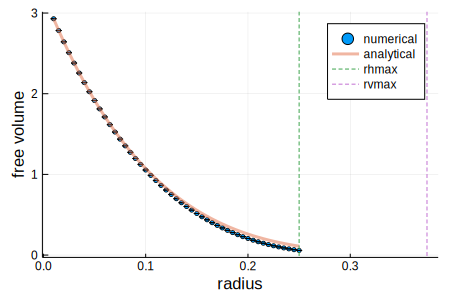

In [87]:
scatter(rs, numerical_V_data, yerror = 2 .* sigma_V_data, markersize=2, lab="numerical", xlabel="radius", ylabel ="free volume")

plot!(rs, exact_V_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
vline!([rhmax], ls=:dash, label="rhmax")
vline!([rvmax], ls=:dash, label="rvmax")

In [29]:
savefig("figures/FreeVolume3D01.pdf")

SystemError: SystemError: opening file /home/karel/ProblemasSanders/TwoDiskinaRectangle/julia_code/figures/FreeVolume3D01.pdf: No such file or directory

## MC calculation of hopping areas

In [13]:
area_vert_hop(a, b, r)  = 16 * √2 * b * (r - a)^2 
area_horiz_hop(a, b, r) = area_vert_hop(b, a, r)

area_horiz_hop (generic function with 1 method)

In [14]:
rs_A, numerical_A_hop_data, sigma_A_hop_data, exact_A_hop_data = run_MC(MC_horiz_hop_area, area_horiz_hop, rhmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.105 0.11 0.115 0.12 0.125 0.13 0.135 0.14 0.145 0.15 0.155 0.16 0.165 0.17 0.175 0.18 0.185 0.19 0.195 0.2 0.205 0.21 0.215 0.22 0.225 0.23 0.235 0.24 0.245 0.25 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25], [1.9319, 1.85173, 1.76607, 1.65216, 1.55593, 1.5075, 1.43114, 1.35066, 1.28611, 1.18913  …  0.0514491, 0.0390611, 0.0295909, 0.0227273, 0.0144575, 0.00972992, 0.00515552, 0.00226466, 0.000437791, 0.0], [0.0142418, 0.0137078, 0.013159, 0.012509, 0.0119289, 0.0115362, 0.0110417, 0.0105357, 0.0100959, 0.00953164  …  0.00103133, 0.000875318, 0.000741802, 0.000632739, 0.000490981, 0.0003917, 0.000277158, 0.000178479, 7.62095e-5, 0.0], [3.85788, 3.67382, 3.49521, 3.32199, 3.15408, 2.99142, 2.83395, 2.68159, 2.53427, 2.39193  …  0.0998887, 0.0782004, 0.0593178, 0.0431731, 0.0296985, 0.018826, 0.0104878, 0.00461599, 0.00114268, 0.0])

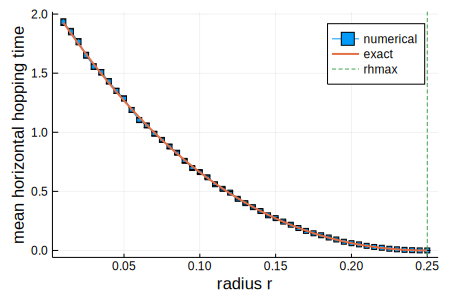

In [15]:
plot(rs_A, numerical_A_hop_data, yerr=2 .* sigma_A_hop_data, m=:square, markersize=2, lab="numerical")
plot!(rs_A, exact_A_hop_data/2, lw=2, lab="exact", size=(450, 300))
xlabel!("radius r")
ylabel!("mean horizontal hopping time")
vline!([rhmax], label="rhmax", ls=:dash)

In [16]:
savefig("figures/AreaHop01.pdf")

In [17]:
# plot(rs, exact_A_data/2 ./ num_A_data, m=:square)


## Area for disc collisions

In [18]:
area_col_free(a, b, r) = (16*π*a*b*r-32*(a+b)*r^2+16*r^3)*√(2) 

exprcircular_col(a, b, r, θ)=16*√2*(2*a*b*r*θ + 2*r^2*(a*cos(θ)-b*sin(θ)) + r^3*sin(θ)^2 )

function area_col(a, b, r)
    if (r<rhmax)
        result=area_col_free(a,b,r)
    elseif (rhmax<=r) && (r<rvmax)
     #   println(b, " ", r, " ", b/r)
        α=asin(b/r)
        result=exprcircular_col(a,b,r,α)-exprcircular_col(a,b,r,0)
    else
        α=asin(b/r)
        β=acos(a/r)        
        result=exprcircular_col(a,b,r,α)-exprcircular_col(a,b,r,β)   
    end
  #  print(" acol= ",result,  " \n ")
    return result
end

area_col (generic function with 1 method)

In [19]:
rs_C, num_C_data, sigma_C_data, exact_C_data = run_MC(MC_collision_area, area_col, rmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045000000000000005 0.05 0.055 0.060000000000000005 0.065 0.06999999999999999 0.075 0.08 0.08499999999999999 0.09 0.095 0.09999999999999999 0.105 0.11 0.11499999999999999 0.12 0.125 0.13 0.135 0.14 0.14500000000000002 0.15000000000000002 0.155 0.16 0.165 0.17 0.17500000000000002 0.18000000000000002 0.18500000000000003 0.19 0.195 0.2 0.20500000000000002 0.21000000000000002 0.21500000000000002 0.22 0.225 0.23 0.23500000000000001 0.24000000000000002 0.24500000000000002 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.28500000000000003 0.29000000000000004 0.29500000000000004 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.34500000000000003 0.35000000000000003 0.35500000000000004 0.36000000000000004 0.365 0.37 0.375 0.38 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38], [0.257278, 0.367804, 0.483459, 0.59335, 0.681407, 0.773424, 0.841735, 0.949118, 1.00082, 1.069  …  0.0547055, 0.0452576, 0.0366201, 0.0282816, 0.0214724, 0.0153255, 0.0100492, 0.004951, 0.00119531, 8.83169e-5], [0.00735635, 0.00864685, 0.0097443, 0.0106091, 0.0111715, 0.0116932, 0.0119828, 0.0124967, 0.0126012, 0.0127862  …  0.000640397, 0.000558042, 0.000480375, 0.000403512, 0.000335642, 0.000270328, 0.000208387, 0.000139029, 6.48238e-5, 1.66903e-5], [0.252215, 0.36776, 0.476449, 0.57842, 0.673809, 0.762757, 0.8454, 0.921878, 0.992327, 1.05689  …  0.054874, 0.0452552, 0.0365678, 0.0287603, 0.0217837, 0.0155909, 0.0101368, 0.00537755, 0.0012707, 7.54195e-5])

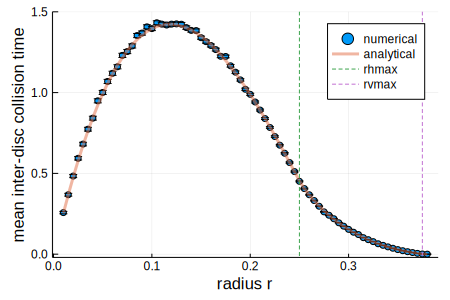

In [20]:
scatter(rs_C, num_C_data, yerror=sigma_C_data, markersize=3, lab="numerical", ylim=(-0.02,1.5))
plot!(rs_C, exact_C_data, lab="analytical", lw=3, alpha=0.5, size=(450, 300))
xlabel!("radius r")
ylabel!("mean inter-disc collision time")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [21]:
savefig("figures/AreaCol01.pdf")

In [22]:
# plot(rs, exact_C_data ./ num_C_data, m=:square)

## Area for wall collisions

In [119]:
area_wall_free(a, b, r) = 8*a*b^2 - 4*π*b*r^2 + 16/3*r^3 #perfect but needs generalization

exprpos_wall(a, b, r) = 8*a*b^2
exprcircular_wall(a, b, r, θ) = 8*b*r^2*θ + 16/3*r^3*cos(θ) #sector

# "upper triangle"
a_wall_uppt(a, b, r) = 8/3*b^2*sqrt(r^2 - b^2)
a_wall_lowt(a, b, r) = a_wall_uppt(b, a, r)

function area_wall(a, b, r)
    if (r < rhmax)
        result = area_wall_free(a, b, r)
        
    elseif (rhmax <= r) && (r < rvmax)
         α = asin(b / r)
        
         negative = exprcircular_wall(a, b, r, α) - exprcircular_wall(a, b, r, 0) + a_wall_uppt(a, b, r)
         result = exprpos_wall(a, b, r) - negative  # delete factor of 2 accounting for volume splitting
    else
        α = asin(b / r)
        β = acos(a / r)

        negative = 0 # (exprcircular_wall(a,b,r,α)-exprcircular_wall(a,b,r,β))+a_wall_uppt(a,b,r)+a_wall_lowt(a,b,r)
        result = exprpos_wall(a, b, r) - negative  # delete factor of 4 accounting for volume splitting
    end
    
    return result
end

area_wall (generic function with 1 method)

In [117]:
rs_W, num_W_data, sigma_W_data, exact_W_data = run_MC(MC_wall_area, area_wall, rmax, 10^7)

0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045000000000000005 0.05 0.055 0.060000000000000005 0.065 0.06999999999999999 0.075 0.08 0.08499999999999999 0.09 0.095 0.09999999999999999 0.105 0.11 0.11499999999999999 0.12 0.125 0.13 0.135 0.14 0.14500000000000002 0.15000000000000002 0.155 0.16 0.165 0.17 0.17500000000000002 0.18000000000000002 0.18500000000000003 0.19 0.195 0.2 0.20500000000000002 0.21000000000000002 0.21500000000000002 0.22 0.225 0.23 0.23500000000000001 0.24000000000000002 0.24500000000000002 0.25 0.255 0.26 0.265 0.27 0.275 0.28 0.28500000000000003 0.29000000000000004 0.29500000000000004 0.3 0.305 0.31 0.315 0.32 0.325 0.33 0.335 0.34 0.34500000000000003 0.35000000000000003 0.35500000000000004 0.36000000000000004 0.365 0.37 0.375 0.38 

([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055  …  0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38], [1.42313, 1.37708, 1.34646, 1.31497, 1.26791, 1.23132, 1.20014, 1.16034, 1.12624, 1.08369  …  0.0190554, 0.0154852, 0.0127805, 0.0100685, 0.00787302, 0.005285, 0.00336703, 0.00172973, 0.0003375, 1.26167e-5], [0.0172967, 0.0167271, 0.0162582, 0.0157906, 0.0152364, 0.0147521, 0.0143067, 0.0138166, 0.013367, 0.0128737  …  0.000378047, 0.000326493, 0.000283842, 0.000240799, 0.000203265, 0.000158764, 0.000120632, 8.218e-5, 3.44458e-5, 6.30835e-6], [1.42078, 1.38177, 1.34317, 1.30498, 1.26721, 1.22988, 1.19298, 1.15653, 1.12053, 1.08499  …  0.0189374, 0.0156513, 0.0126712, 0.00998294, 0.00757265, 0.00542663, 0.00353129, 0.00187319, 0.046875, 0.042624])

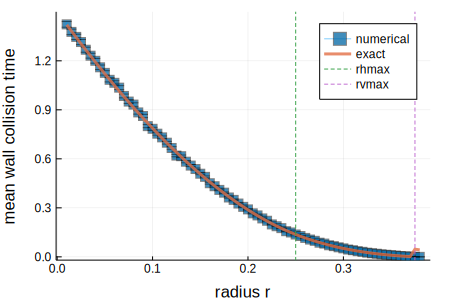

In [135]:
plot(rs_W, num_W_data, yerror=sigma_W_data, m=:square, lab="numerical", ylim=(-0.02,1.5), alpha=0.5)
plot!(rs_W, exact_W_data, lab="exact", lw=3, size=(450, 300), alpha=0.8)
xlabel!("radius r")
ylabel!("mean wall collision time")
vline!([rhmax], label="rhmax", ls=:dash)
vline!([rvmax], label="rvmax", ls=:dash)

In [136]:
savefig("figures/AreaWall01.pdf")

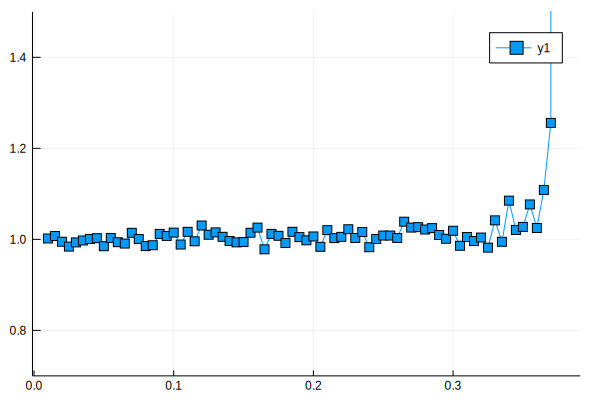

In [63]:
# plot(rs, exact_W_data ./ num_W_data, m=:square, ylim=(0.7,1.5))